<a href="https://colab.research.google.com/github/ZS520L/Hello-World/blob/main/%E5%A4%A7%E4%BD%9C%E4%B8%9A_%E9%9F%B3%E9%A2%91%E5%8A%A0%E5%99%AA%E5%8E%BB%E5%99%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub

# flac转wav

In [ ]:
from pathlib import PurePath
from pydub import AudioSegment

file_path = PurePath("test.flac")

flac_tmp_audio_data = AudioSegment.from_file(file_path, file_path.suffix[1:])

flac_tmp_audio_data.export(file_path.name.replace(file_path.suffix, "") + ".wav", format="wav")

<_io.BufferedRandom name='test.wav'>

# 截取十秒

In [ ]:
from pydub import AudioSegment
filePath = './'
 
# 操作函数
def get_wav_make(dataDir):
    sound= AudioSegment.from_wav(dataDir)
    duration = sound.duration_seconds * 1000  # 音频时长（ms）
    begin = 0
    end = int(duration/2)
    cut_wav = sound[70000:80000]   #以毫秒为单位截取[begin, end]区间的音频
    cut_wav.export(filePath+ 'test1.wav', format='wav')   #存储新的wav文件
get_wav_make('/content/test.wav')

# 双通道转单通道

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


(882000,)
[-12087 -12219 -13839 ...  11892  13022  13924]


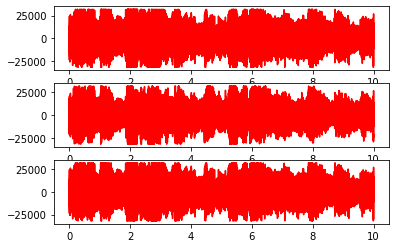

In [ ]:
import wave
import numpy as np
import struct
import matplotlib.pyplot as plt

# 只读方式打开WAV文件
wf = wave.open(r'test1.wav', 'rb')

nframes = wf.getnframes()
framerate = wf.getframerate()
str_data = wf.readframes(nframes)
sample_width = wf.getsampwidth()
wf.close()

# 将波形数据转换成数组
wave_data = np.fromstring(str_data, dtype=np.short)
print(wave_data.shape)
wave_data.shape = (-1, 2)
wave_data = wave_data.T
mono_wave = (wave_data[0])
print(mono_wave)

time = np.arange(0, nframes)*(1.0/framerate)

plt.subplot(311)
plt.plot(time, wave_data[0], c='r')
plt.subplot(312)
plt.plot(time, wave_data[1], c='r')
plt.subplot(313)
plt.plot(time, mono_wave, c='r')
plt.show()

#save wav file
wf_mono = wave.open("mono.wav",'wb')
wf_mono.setnchannels(1)
wf_mono.setframerate(framerate)
wf_mono.setsampwidth(sample_width)
for i in mono_wave:
    data = struct.pack('<h', int(i))
    wf_mono.writeframesraw( data )
wf_mono.close()

# 时域波形展示

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


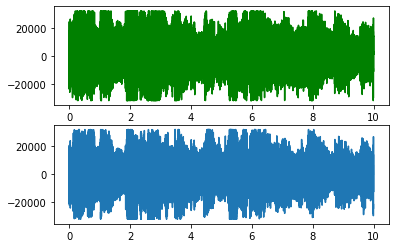

In [ ]:
#wave data   -xlxw

#import
import wave as we
import numpy as np
import matplotlib.pyplot as plt

def wavread(path):
    wavfile =  we.open(path,"rb")
    params = wavfile.getparams()
    framesra,frameswav= params[2],params[3]
    datawav = wavfile.readframes(frameswav)
    wavfile.close()
    datause = np.fromstring(datawav,dtype = np.short)
    datause.shape = -1,2
    datause = datause.T
    time = np.arange(0, frameswav) * (1.0/framesra)
    return datause,time

def main():
    path = 'test1.wav'
    wavdata,wavtime = wavread(path)
    plt.title("Night.wav's Frames")
    plt.subplot(211)
    plt.plot(wavtime, wavdata[0],color = 'green')
    plt.subplot(212)
    plt.plot(wavtime, wavdata[1])
    plt.show()
    return wavdata[0]
    
datas = main()

# 谱减法语音降噪

In [ ]:
import ctypes as ct


class FloatBits(ct.Structure):
    _fields_ = [
        ('M', ct.c_uint, 23),
        ('E', ct.c_uint, 8),
        ('S', ct.c_uint, 1)
    ]


class Float(ct.Union):
    _anonymous_ = ('bits',)
    _fields_ = [
        ('value', ct.c_float),
        ('bits', FloatBits)
    ]


def nextpow2(x):
    if x < 0:
        x = -x
    if x == 0:
        return 0
    d = Float()
    d.value = x
    if d.M == 0:
        return d.E - 127
    return d.E - 127 + 1

In [ ]:
#!/usr/bin/env python
import numpy as np
import wave
import math

# 打开WAV文档
f = wave.open("test1.wav")
# 读取格式信息
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate
# 读取波形数据
str_data = f.readframes(nframes)
f.close()
# 将波形数据转换为数组
x = np.fromstring(str_data, dtype=np.short)
# 计算参数
len_ = 20 * fs // 1000 # 样本中帧的大小
PERC = 50 # 窗口重叠占帧的百分比
len1 = len_ * PERC // 100  # 重叠窗口
len2 = len_ - len1   # 非重叠窗口
# 设置默认参数
Thres = 3
Expnt = 2.0
beta = 0.002
G = 0.9
# 初始化汉明窗
win = np.hamming(len_)
# normalization gain for overlap+add with 50% overlap
winGain = len2 / sum(win)

# Noise magnitude calculations - assuming that the first 5 frames is noise/silence
nFFT = 2 * 2 ** (nextpow2(len_))
noise_mean = np.zeros(nFFT)

j = 0
for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win * x[j:j + len_], nFFT))
    j = j + len_
noise_mu = noise_mean / 5

# --- allocate memory and initialize various variables
k = 1
img = 1j
x_old = np.zeros(len1)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)

# =========================    Start Processing   ===============================
for n in range(0, Nframes):
    # Windowing
    insign = win * x[k-1:k + len_ - 1]
    # compute fourier transform of a frame
    spec = np.fft.fft(insign, nFFT)
    # compute the magnitude
    sig = abs(spec)

    # save the noisy phase information
    theta = np.angle(spec)
    SNRseg = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)


    def berouti(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 4 - SNR * 3 / 20
        else:
            if SNR < -5.0:
                a = 5
            if SNR > 20:
                a = 1
        return a


    def berouti1(SNR):
        if -5.0 <= SNR <= 20.0:
            a = 3 - SNR * 2 / 20
        else:
            if SNR < -5.0:
                a = 4
            if SNR > 20:
                a = 1
        return a

    if Expnt == 1.0:  # 幅度谱
        alpha = berouti1(SNRseg)
    else:  # 功率谱
        alpha = berouti(SNRseg)
    #############
    sub_speech = sig ** Expnt - alpha * noise_mu ** Expnt;
    # 当纯净信号小于噪声信号的功率时
    diffw = sub_speech - beta * noise_mu ** Expnt
    # beta negative components

    def find_index(x_list):
        index_list = []
        for i in range(len(x_list)):
            if x_list[i] < 0:
                index_list.append(i)
        return index_list

    z = find_index(diffw)
    if len(z) > 0:
        # 用估计出来的噪声信号表示下限值
        sub_speech[z] = beta * noise_mu[z] ** Expnt
        # --- implement a simple VAD detector --------------
    if SNRseg < Thres:  # Update noise spectrum
        noise_temp = G * noise_mu ** Expnt + (1 - G) * sig ** Expnt  # 平滑处理噪声功率谱
        noise_mu = noise_temp ** (1 / Expnt)  # 新的噪声幅度谱
    # flipud函数实现矩阵的上下翻转，是以矩阵的“水平中线”为对称轴
    # 交换上下对称元素
    sub_speech[nFFT // 2 + 1:nFFT] = np.flipud(sub_speech[1:nFFT // 2])
    x_phase = (sub_speech ** (1 / Expnt)) * (np.array([math.cos(x) for x in theta]) + img * (np.array([math.sin(x) for x in theta])))
    # take the IFFT

    xi = np.fft.ifft(x_phase).real
    # --- Overlap and add ---------------
    xfinal[k-1:k + len2 - 1] = x_old + xi[0:len1]
    x_old = xi[0 + len1:len_]
    k = k + len2
# 保存文件
wf = wave.open('en_outfile.wav', 'wb')
# 设置参数
wf.setparams(params)
# 设置波形文件 .tostring()将array转换为data
wave_data = (winGain * xfinal).astype(np.short)
wf.writeframes(wave_data.tostring())
wf.close()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


# 频谱图绘制

In [ ]:
import wave as we
import numpy as np
import matplotlib.pyplot as plt

def read_wav(wavfile, plots=True, normal=False):
    f = wavfile
    params = f.getparams()
    # print(params)
    nchannels, sampwidth, framerate, nframes = params[:4]
    strData = f.readframes(nframes)  # 读取音频，字符串格式
    waveData = np.frombuffer(strData, dtype=np.int16)  # 将字符串转化为int
    # wave幅值归一化
    if normal == True:
        waveData = waveData*1.0/(max(abs(waveData)))
    # 绘图
    waveData = waveData[:441000]
    if plots == True:
        time = np.arange(0, nframes)*(1.0 / framerate)
        plt.figure(dpi=100)
        plt.plot(time, waveData)
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.title("Single channel wavedata")
        plt.show()
    return (waveData, time)

def fft_wav(waveData, plots=True):
    f_array = np.fft.fft(waveData)  # 傅里叶变换，结果为复数数组
    f_abs = f_array
    axis_f = np.linspace(0, 250, np.int(len(f_array)/2))  # 映射到250
    # axis_f = np.linspace(0, 250, np.int(len(f_array)))  # 映射到250
    if plots == True:
        plt.figure(dpi=100)
        plt.plot(axis_f, np.abs(f_abs[0:len(axis_f)]))
        # plt.plot(axis_f, np.abs(f_abs))
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude spectrum")
        plt.title("Tile map")
        plt.show()
    return f_abs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


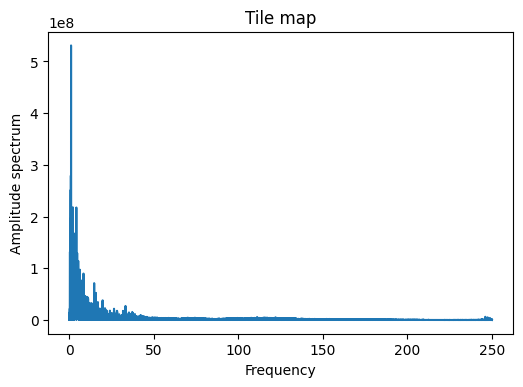

In [ ]:
wavefft = fft_wav(datas)

# 加噪及去噪

In [ ]:
!git clone https://github.com/EoralMilk/WAV-noiser-filter.git

Cloning into 'WAV-noiser-filter'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 22 (delta 6), reused 20 (delta 4), pack-reused 0
Unpacking objects: 100% (22/22), done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


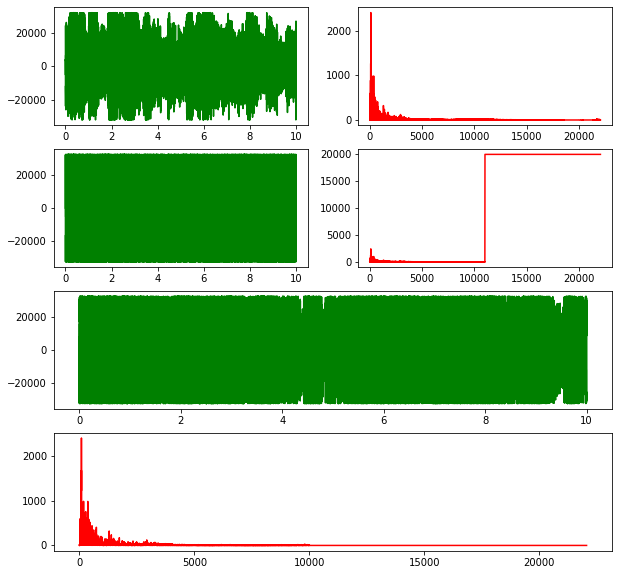

In [ ]:
import wave as we
import numpy as np
import matplotlib.pyplot as plt


def wavread(path):
    wavfile = we.open(path,"rb")                        #打开WAV文件
    params = wavfile.getparams()                        #获取WAV头文件中的参数
    nchannels, sampwidth, framerate, nframes= params[:4]            #获取声道数，量化位数，采样率和帧数
    datawav = wavfile.readframes(nframes)               #读取每一帧数据
    wavfile.close()                                     #关闭文件
    datause = np.fromstring(datawav,dtype = np.short)   #将String格式转换成int型数据
    datause.shape = -1,nchannels                        #将横向矩阵转为纵向矩阵，注意声道数
    datause = datause.T	                                #矩阵转置
    time = np.arange(0, nframes) * (1.0/framerate)      #返回一个时间长度的list
    return datause,time,nchannels, sampwidth, framerate, nframes

def getfreq(datause,nframes,framerate,start):   # 时域转频域
    N = nframes                                 # 采样点数，修改采样点数进行不同位置和长度的音频波形分析
    df = framerate/(N-1)                        # 分辨率
    freq = [df*n for n in range(0,N)]           # N个元素
    tempdata = datause[0][start:start+N]
    freqdata = np.fft.fft(tempdata)*2/N
    d=int(len(freqdata)/2)                      # 常规显示采样频率一半的频谱
    return freq,d,freqdata

def freq2time(nframes,freqdata):    # 频域转时域
    fdata = freqdata*nframes
    filter_sig = np.fft.ifft(fdata).real
    data = filter_sig.astype(np.short)
    return data


def filter(freq,d,freqdata): # 滤波器
    while d:
        d-=1
        if freq[d] > 10000:  # 滤除频率10000以上部分
            freqdata[d]=0
    return freqdata

def noiser(freq,d,freqdata): # 制造噪音
    while d:
        d-=1
        if freq[d] >= 11000: #在11000处添强烈噪音
            freqdata[d]=20000 #噪音强度要足够高效果才明显
    return freqdata

def wavwrite(path, nchannels, sampwidth, framerate, wave_data):
    # 打开WAV文档
    wavfile = we.open(path, "wb")
    # 配置声道数、量化位数和取样频率
    wavfile.setnchannels(nchannels)
    wavfile.setsampwidth(sampwidth)
    wavfile.setframerate(framerate)
    # 将wav_data转换为二进制数据写入文件
    wavfile.writeframes(wave_data.tostring())
    wavfile.close()


def main():
    path = 'mono.wav' #input("The Path is:")             #这是一个单声道的wav文件
    # 读取文件
    wavdata,wavtime,nchannels, sampwidth, framerate, nframes = wavread(path)
    
    freq,d,freqdata = getfreq(wavdata,nframes,framerate,0) # 获得频域信号
    # 滤波前波形绘制
    plt.figure(figsize=(10, 10))
    plt.subplot(421)                                    
    plt.plot(wavtime, wavdata[0],color = 'green')       #时域
    plt.subplot(422)                                    
    plt.plot(freq[:d-1],abs(freqdata[:d-1]),'r')        #频域

    freqdata_n = noiser(freq,d,freqdata)                #噪声加入！
    data_n = freq2time(nframes,freqdata_n)              #fft逆变换将噪声频域转时域
    # 噪声后波形绘制
    plt.subplot(423)                                    
    plt.plot(wavtime, data_n, color = 'green')          #噪声后时域
    plt.subplot(424)                                    
    plt.plot(freq[:d-1],abs(freqdata_n[:d-1]),'r')      #噪声后频域

    # 写入加入噪声的文件
    wavwrite('evan.wav', nchannels, sampwidth, framerate, data_n)

    freqdata_f = filter(freq,d,freqdata)                #滤波
    data_f = freq2time(nframes,freqdata_f)              #fft逆变换转回时域
    # 滤波后波形绘制
    plt.subplot(413)                                    
    plt.plot(wavtime, data_f, color = 'green')          #滤波后时域
    plt.subplot(414)                                    
    plt.plot(freq[:d-1],abs(freqdata_f[:d-1]),'r')      #滤波后频域

    # 写入滤除噪声后的文件
    wavwrite('evaf.wav', nchannels, sampwidth, framerate, data_f)

    plt.show()




if __name__ == "__main__":
    main()

# 低通滤频器幅频响应波形

[7. 3. 6. 5. 7. 3. 5. 5. 6. 3.]


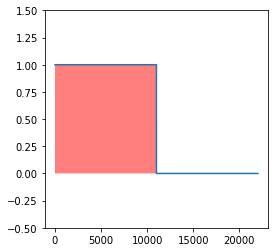

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 设置numpy的随机种子，保证每次随机得到的值一致
np.random.seed(233)
# 定义一个10个长度的，每个元素为0的array
zero_array = np.zeros(shape=[10, ])
# 使用5对上面的数组进行填充
zero_array.fill(5)
# 生成10随机数的数组，最大值为3，最小值为-3
random_num = np.random.randint(low=-3, high=3, size=10)
fill_array = zero_array + random_num
print(fill_array)

# 设置画布个数和尺寸
fig = plt.figure(num=1, figsize=[4, 4])

# # 绘制第一个子图，没有填充
# plt.subplot(131)
# plt.plot(fill_array)
# plt.ylim([-0.5, 10.5])

# 绘制第二个子图，在竖直方向进行填充， facecolor为填充的颜色，alpha为透明度
# plt.subplot(132)
plt.plot([0,11000,11001,22000],[1,1,0,0])
plt.ylim([-0.5, 1.5])
plt.fill_between(x=[0,11000,11001,15000], y1=1, y2=[0,0,1,1], facecolor='red', alpha=0.5)

# # 绘制第三个子图，在水平方向进行填充
# plt.subplot(133)
# plt.plot(fill_array)
# plt.ylim([-0.5, 10.5])
# plt.fill_betweenx(x1=0, x2=fill_array, y=range(10, 0, -1), facecolor='green', alpha=0.3)

plt.show()
